<a href="https://colab.research.google.com/github/balawillgetyou/2021/blob/main/anomalyDetection20210203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

import datetime

In [ ]:
# Generated training sequences for use in the model.
TIME_STEPS = 6*8#must be a multiple of 8
Kernel_Size = 6#must also be a factor of TIME_STEPS
Strides = 2
rollingOffset = 24

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

def reverse_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values)-1):
        output.append(values[i][0])
    return np.stack(output)

def std_scaler(trainData):
    ss = StandardScaler()
    df_training_value = ss.fit_transform(trainData)
    return df_training_value, ss




def tcnn_model(df_training_value,numVariables):#kernel_size reset to 6 to cover just one full day 
    #converting training data to sequences
    x_train = create_sequences(df_training_value)
    #model definition
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=64, kernel_size=Kernel_Size, padding="same", strides=Strides, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=32, kernel_size=Kernel_Size, padding="same", strides=Strides, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=Kernel_Size, padding="same", strides=Strides, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=Kernel_Size, padding="same", strides=Strides, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=Kernel_Size, padding="same", strides=Strides, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=64, kernel_size=Kernel_Size, padding="same", strides=Strides, activation="relu"
            ),
            layers.Conv1DTranspose(filters=numVariables, kernel_size=Kernel_Size, padding="same"),
            ]
        )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    #model training
    history = model.fit(
        x_train,
        x_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return model

def inverseTransform(objForTrfm, typTrfm, **kwargs):
    rs = kwargs.get('rs', None)
    ss = kwargs.get('ss', None)
    
    if typTrfm == 'RobustScaler':
        objTrfm = rs.inverse_transform(objForTrfm)
    if typTrfm == 'StandardScaler':
        objTrfm = ss.inverse_transform(objForTrfm)
    return objTrfm


def reconstructTimeSeries(df_training_value, model, trainData, df_testing_value, testData, typTrfm, colNames, **kwargs):
    #this flattens data from sequences format to simple time series
    rs = kwargs.get('rs', None)
    ss = kwargs.get('ss', None)
    
    x_train = create_sequences(df_training_value)
    x_train_pred = model.predict(x_train)
    x_train_pred_flat = pd.DataFrame(reverse_sequences((x_train_pred)))

    trainData_trimmed = trainData[0:len(x_train_pred_flat)]

    if typTrfm == 'RobustScaler':
        trainData_pred = inverseTransform(x_train_pred_flat, 'RobustScaler', rs = rs)
    if typTrfm == 'StandardScaler':
        trainData_pred = inverseTransform(x_train_pred_flat, 'StandardScaler', ss = ss)
    
    trainData_pred = pd.DataFrame(trainData_pred)
    trainData_pred.columns = colNames
    trainData_pred.set_index(trainData_trimmed.index, inplace=True)
    
    x_test = create_sequences(df_testing_value)
    x_test_pred = model.predict(x_test)
    x_test_pred_flat = pd.DataFrame(reverse_sequences((x_test_pred)))

    testData_trimmed = testData[0:len(x_test_pred_flat)]

    if typTrfm == 'RobustScaler':
        testData_pred = inverseTransform(x_test_pred_flat, 'RobustScaler', rs = rs)
    if typTrfm == 'StandardScaler':
        testData_pred = inverseTransform(x_test_pred_flat, 'StandardScaler', ss = ss)

    testData_pred = pd.DataFrame(testData_pred)
    testData_pred.columns = colNames
    testData_pred.set_index(testData_trimmed.index, inplace=True)
    return trainData_trimmed, trainData_pred, testData_trimmed, testData_pred

def plot_reconstructed_timeseries(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, typTrfm, colNames):
    #only to see reconstruction, not anomalies
    for i, col in enumerate(colNames):
        fig, ax = plt.subplots(figsize=(15,3))
        trainData_trimmed[col].plot(label='Train_Actual', ax=ax)
        trainData_pred[col].plot(label='Train_Predicted', ax=ax)
        testData_trimmed[col].plot(label='Test_Actual', ax=ax)
        testData_pred[col].plot(label='Test_Predicted', ax=ax)
        #ylim_list=[(-1,5),(-0.5,2.5),(0,1),(-1,5),(-0.5,15)]#changed
        #ax.set_ylim(ylim_list[i])#changed
        plt.legend()
        plt.title('{} / {} / Multivariate'.format(typTrfm, col))
        plt.show()
        
def anomalyFlaggingAttribution(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, **kwargs):
    #note the use of scaled features so that anomaly contribution by feature is not skewed towards features with larger values
    rs = kwargs.get('rs', None)
    ss = kwargs.get('ss', None)
    
    if rs:
        trainData_trimmed_scaled = rs.transform(trainData_trimmed)
        trainData_pred_scaled = rs.transform(trainData_pred)
        testData_trimmed_scaled = rs.transform(testData_trimmed)
        testData_pred_scaled = rs.transform(testData_pred)
    if ss:
        trainData_trimmed_scaled = ss.transform(trainData_trimmed)
        trainData_pred_scaled = ss.transform(trainData_pred)
        testData_trimmed_scaled = ss.transform(testData_trimmed)
        testData_pred_scaled = ss.transform(testData_pred)
    
    #calculating training reconstruction error and identifying anomaly threshold
    train_mae_loss = np.abs(trainData_pred_scaled - trainData_trimmed_scaled)
    train_mae_loss = pd.DataFrame(train_mae_loss)
    train_mae_loss.columns = colNames
    train_mae_loss = train_mae_loss.add_suffix('_mae_loss')
    train_mae_loss_sum = np.sum(train_mae_loss,axis=1)
    train_mae_loss = pd.concat([pd.DataFrame(train_mae_loss), (pd.DataFrame(train_mae_loss_sum,columns=['Sum_mae_loss']))], axis='columns')
    #threshold = np.median(train_mae_loss, axis=0)
    threshold = np.quantile(train_mae_loss, 0.99, axis=0)
    #threshold = np.max(train_mae_loss) #max is the right choice but is not picking many anomalies in this dataset
    #print("Reconstruction error threshold: ", threshold)
    
    #calculating test losses on a rolling window
    test_mae_loss = np.abs(testData_pred_scaled - testData_trimmed_scaled)
    test_mae_loss = pd.DataFrame(test_mae_loss)
    test_mae_loss.columns = colNames
    test_mae_loss = test_mae_loss.add_suffix('_mae_loss')
    test_mae_loss_sum = np.sum(test_mae_loss,axis=1)
    test_mae_loss = pd.concat([pd.DataFrame(test_mae_loss), (pd.DataFrame(test_mae_loss_sum,columns=['Sum_mae_loss']))], axis='columns')

    test_mae_loss.set_index(testData_trimmed.index, inplace=True)
    test_mae_loss_rolling = test_mae_loss.rolling(rollingOffset).mean()
    
    # # Detect all the samples which are anomalies + which feature has the highest loss
    anomaly_data = pd.DataFrame(test_mae_loss_rolling > threshold)
    anomaly_data['top_contrib'] = test_mae_loss_rolling[test_mae_loss_rolling.columns[:-1]].idxmax(axis=1)
    anomaly_data.set_index(testData_trimmed.index, inplace=True)
    return test_mae_loss, test_mae_loss_rolling, anomaly_data

def plot_anomaly(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, **kwargs):
    #shows any anomaly markers on test data
    rs = kwargs.get('rs', None)
    ss = kwargs.get('ss', None)
    
    if rs:
        test_mae_loss, test_mae_loss_rolling, anomaly_data = anomalyFlaggingAttribution(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, rs = rs)
    if ss:
        test_mae_loss, test_mae_loss_rolling, anomaly_data = anomalyFlaggingAttribution(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, ss = ss)
    
    for i, col in enumerate(colNames):
        anomaly_data_indices = []
        for data_idx in range(len(testData_trimmed)):
            if np.all(anomaly_data[anomaly_data.columns[i]][data_idx]):
                anomaly_data_indices.append(data_idx)
        df_subset = testData_trimmed[colNames[i]].iloc[anomaly_data_indices]
        #fig, ax = plt.subplots(figsize=(15,3))
        #ax.plot(testData_trimmed[colNames[i]])
        if (len(df_subset)>0):#adds markers for anomalies, if any/ only anomalous features are plotted
            fig, ax = plt.subplots(figsize=(15,3))
            ax.plot(testData_trimmed[colNames[i]])
            ax.plot(df_subset.index,df_subset, '+', color="r")
            plt.title(col)
            plt.show()
            
def plot_anomaly1(subColPhrase, sub_anomaly_data, testData_trimmed):
    #shows any anomaly markers on test data
    subCol = testData_trimmed.filter(regex=subColPhrase).columns
    for i, col in enumerate(subCol):
        sub_anomaly_data_indices = []
        for data_idx in range(len(testData_trimmed[subCol])):
            if np.all(sub_anomaly_data[sub_anomaly_data.columns[i]][data_idx]):
                sub_anomaly_data_indices.append(data_idx)
        df_subset = testData_trimmed[col].iloc[sub_anomaly_data_indices]
        if (len(df_subset)>0):#adds markers for anomalies, if any/ only anomalous features are plotted
            fig, ax = plt.subplots(figsize=(15,3))
            ax.plot(testData_trimmed[col])
            ax.plot(df_subset.index,df_subset, '+', color="r")
            plt.title(col)
            plt.show()

def metricsRollUp(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, subColPhrase, **kwargs):
    #rolls up anomalies from individual features to systems 
    rs = kwargs.get('rs', None)
    ss = kwargs.get('ss', None)
    
    if rs:
        test_mae_loss, test_mae_loss_rolling, anomaly_data = anomalyFlaggingAttribution(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, rs = rs)
    if ss:
        test_mae_loss, test_mae_loss_rolling, anomaly_data = anomalyFlaggingAttribution(trainData_trimmed, trainData_pred, testData_trimmed, testData_pred, colNames, rollingOffset, ss = ss)

    subCol = anomaly_data.filter(regex=subColPhrase).columns#matching columns in anomaly data (has the mae loss suffix)
    subCol1 = testData_trimmed.filter(regex=subColPhrase).columns#matching columns in test data
    sub_anomaly_data = anomaly_data[subCol]
    sub_anomaly_data['rolledUp'] = sub_anomaly_data.any(axis='columns')

    anomIndex = sub_anomaly_data.index[sub_anomaly_data['rolledUp'] == True]#timestamps for anomaly in any feature
    fig, ax = plt.subplots(figsize=(15,3))
    testData_trimmed[subCol1[0]].plot(figsize=(15,3), color = 'w')#using a random column and suppressing the line, then adding vlines where anomalies occur
    plt.title('Anomalies')
    for i in anomIndex:
        ax.axvline(i, alpha=0.3, color='red')
    
    plot_anomaly1(subColPhrase, sub_anomaly_data, testData_trimmed)
            
    return sub_anomaly_data

## Data download from Kaggle dataset

In [ ]:
# ! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list -s kdd
!kaggle datasets download -d galaxyh/kdd-cup-1999-data
!unzip kdd-cup-1999-data.zip

Saving kaggle.json to kaggle.json
ref                                                      title                                           size  lastUpdated          downloadCount  
-------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
hassan06/nslkdd                                          NSL-KDD                                         14MB  2019-04-25 06:13:16           3931  
galaxyh/kdd-cup-1999-data                                KDD Cup 1999 Data                               88MB  2018-12-11 07:15:21           2254  
slashtea/kdd-cyberattack                                 kdd cyberattack                                  2MB  2018-07-28 09:08:49            333  
marklvl/sentiment-labelled-sentences-data-set            Sentiment Labelled Sentences Data Set          326KB  2018-04-24 21:20:20           8856  
kiranmahesh/nslkdd                                       NSL-KDD              

## Data pre-processing

In [ ]:
#path = '/content/kdd/kddcup.data_10_percent_corrected'
path = '/content/kddcup.data_10_percent_corrected'
df = pd.read_csv(path, header=None)
print(df.head())
print('*'*50)
print(df.shape)

   0    1     2   3    4     5   6   ...    35   36   37   38   39   40       41
0   0  tcp  http  SF  181  5450   0  ...  0.11  0.0  0.0  0.0  0.0  0.0  normal.
1   0  tcp  http  SF  239   486   0  ...  0.05  0.0  0.0  0.0  0.0  0.0  normal.
2   0  tcp  http  SF  235  1337   0  ...  0.03  0.0  0.0  0.0  0.0  0.0  normal.
3   0  tcp  http  SF  219  1337   0  ...  0.03  0.0  0.0  0.0  0.0  0.0  normal.
4   0  tcp  http  SF  217  2032   0  ...  0.02  0.0  0.0  0.0  0.0  0.0  normal.

[5 rows x 42 columns]
**************************************************
(494021, 42)


In [ ]:
# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

In [ ]:
print('kdd cup 1999 shape: ',df.shape)
print('kdd cup 1999 outcome column value counts: ',)
df['outcome'].value_counts()

kdd cup 1999 shape:  (494021, 42)
kdd cup 1999 outcome column value counts: 


smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: outcome, dtype: int64

In [ ]:
df_anomaly = df[df['outcome'].map(df['outcome'].value_counts()) < 1000]
df_anomaly['anomaly'] = 'yes'
df_normal = df[df['outcome'].isin(['normal.'])]
df_normal['anomaly'] = 'no'
df1 = pd.concat([df_normal,df_anomaly], axis='rows')
df1.drop('outcome', axis = 'columns', inplace = True)
print('shape of trimmed dataset that includes only \'normal\'')
print('outcome and other outcomes with counts < 1,000')

print(df1.shape)
print('value counts with \'normal\' outcome set')
print('as anomaly \'no\' and others as anomaly \'yes\'')
print(df1['anomaly'].value_counts())

shape of trimmed dataset that includes only 'normal'
outcome and other outcomes with counts < 1,000
(98931, 42)
value counts with 'normal' outcome set
as anomaly 'no' and others as anomaly 'yes'
no     97278
yes     1653
Name: anomaly, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df1.reset_index(inplace=True)
numeric_cols = df1.select_dtypes(include=np.number).columns
print(df1.drop(numeric_cols, axis='columns').columns)
categorical_cols = ['protocol_type', 'service', 'flag']
print(df1[categorical_cols].head())
print(df1[numeric_cols].shape)
print(df1.drop(numeric_cols, axis='columns').shape)

Index(['protocol_type', 'service', 'flag', 'anomaly'], dtype='object')
  protocol_type service flag
0           tcp    http   SF
1           tcp    http   SF
2           tcp    http   SF
3           tcp    http   SF
4           tcp    http   SF
(98931, 39)
(98931, 4)


In [ ]:
df1.columns

Index(['index', 'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'anomaly'],
      dtype='object')

In [ ]:
df1_dummies = pd.get_dummies(df1[categorical_cols])
df1_std_scaled, ss = std_scaler(df1[numeric_cols])
df1_std_scaled = pd.DataFrame(df1_std_scaled)
df1_std_scaled.columns = df1[numeric_cols].columns
print(df1_std_scaled.info())
df2 = pd.concat([df1_std_scaled, df1_dummies, df1['anomaly']], axis='columns')
del df2['index']
print(df2.columns)
print(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98931 entries, 0 to 98930
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        98931 non-null  float64
 1   duration                     98931 non-null  float64
 2   src_bytes                    98931 non-null  float64
 3   dst_bytes                    98931 non-null  float64
 4   land                         98931 non-null  float64
 5   wrong_fragment               98931 non-null  float64
 6   urgent                       98931 non-null  float64
 7   hot                          98931 non-null  float64
 8   num_failed_logins            98931 non-null  float64
 9   logged_in                    98931 non-null  float64
 10  num_compromised              98931 non-null  float64
 11  root_shell                   98931 non-null  float64
 12  su_attempted                 98931 non-null  float64
 13  num_root        

In [ ]:
#splitting train and test data
#print(df2.shape)
df3 = df2[df2['anomaly'] == 'no']
#print(df3.shape)

df3_train, df3_test = train_test_split(df3, test_size=0.05)
df3_train = df3_train.reset_index(drop=True)
print('shape of train data with only \'normal\' records')
del df3_train['anomaly']
print(df3_train.shape)



df3_test = pd.concat([df3_test, df2[df2['anomaly'] == 'yes']])
df3_test = df3_test.reset_index(drop=True)
y1 = df3_test['anomaly']
print('counts and shape of test data with mixed anomaly yes and no records')
print(df3_test['anomaly'].value_counts())
del df3_test['anomaly']
print(df3_test.shape)


shape of train data with only 'normal' records
(92414, 80)
counts and shape of test data with mixed anomaly yes and no records
no     4864
yes    1653
Name: anomaly, dtype: int64
(6517, 80)


In [ ]:
colNames = df3_train.columns
colNames

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'service_IRC', 'service_X11', 'service_auth',
       'service_ctf', 'service_domain', 'service_domain_u', 'service_eco_i',
       'service_ecr_i', 'servi

## Model training

In [ ]:

scaler = 'StandardScaler'
numVariables = df3_train.shape[1]
print(numVariables)

model = tcnn_model(df3_train, numVariables)

currentDateTime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

mname = f"perfMon_model_{scaler}_Multivariate_{currentDateTime}.h5"
print(mname)
model.save(mname)

80
Epoch 1/50
650/650 [==============================] - 55s 82ms/step - loss: 0.3236 - val_loss: 0.2052
Epoch 2/50
650/650 [==============================] - 51s 79ms/step - loss: 0.2653 - val_loss: 0.2023
Epoch 3/50
650/650 [==============================] - 51s 78ms/step - loss: 0.2543 - val_loss: 0.1953
Epoch 4/50
650/650 [==============================] - 51s 79ms/step - loss: 0.2467 - val_loss: 0.1883
Epoch 5/50
650/650 [==============================] - 51s 78ms/step - loss: 0.2383 - val_loss: 0.1842
Epoch 6/50
650/650 [==============================] - 51s 79ms/step - loss: 0.2331 - val_loss: 0.1807
Epoch 7/50
650/650 [==============================] - 52s 80ms/step - loss: 0.2296 - val_loss: 0.1790
Epoch 8/50
650/650 [==============================] - 51s 79ms/step - loss: 0.2271 - val_loss: 0.1763
Epoch 9/50
650/650 [==============================] - 51s 79ms/step - loss: 0.2220 - val_loss: 0.1666
Epoch 10/50
650/650 [==============================] - 51s 79ms/step - loss: 0.

In [ ]:
#mname = 'perfMon_model_StandardScaler_Multivariate_2021-02-03 04:10:39.h5'
#mname = '/content/perfMon_model_StandardScaler_Multivariate_2021-02-03 04:10:39.h5'
#model = keras.models.load_model(mname)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 64)            30784     
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 32)            12320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 16)             3088      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 12, 16)            1552      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 16)            0

## Model evaluation

In [ ]:
#preparing test data, making predictions, post processing
x_test = create_sequences(df3_test)
x_test_pred = model.predict(x_test)
x_test_pred_flat = pd.DataFrame(reverse_sequences((x_test_pred)))
df3_test_trimmed = df3_test[0:len(x_test_pred_flat)]
y = y1[0:len(x_test_pred_flat)]

In [ ]:
#calculating reconstruction error/ loss
test_mae_loss = np.abs(df3_test_trimmed - x_test_pred_flat.values)
test_mae_loss = pd.DataFrame(test_mae_loss)
test_mae_loss.columns = colNames
test_mae_loss = test_mae_loss.add_suffix('_mae_loss')
test_mae_loss_sum = np.sum(test_mae_loss,axis=1)
test_mae_loss = pd.concat([pd.DataFrame(test_mae_loss), (pd.DataFrame(test_mae_loss_sum,columns=['Sum_mae_loss']))], axis='columns')

In [ ]:
#tuning reconstruction error threshold
resultsDF = pd.DataFrame()
for i in (np.linspace(.50,1,50,endpoint=False)):
  threshold = np.quantile(test_mae_loss, i, axis=0)
  test_mae_loss_rolling = test_mae_loss.rolling(rollingOffset).mean()
  anomaly_data = pd.DataFrame(test_mae_loss_rolling > threshold)
  y_pred = anomaly_data['Sum_mae_loss'].map({False:'no', True:'yes'})
  precision, recall, fscore, support = score(y, y_pred, labels = ['no', 'yes'])
  results1 = pd.concat((pd.Series(['no', 'yes']), pd.Series(precision), pd.Series(recall), pd.Series(fscore), pd.Series(support)), axis=1, join = 'outer')
  results1 = pd.concat([results1, pd.Series([i,i])], axis='columns')
  results1.columns=('anomaly','precision', 'recall', 'fscore', 'support','threshold')
  resultsDF = pd.concat([resultsDF,results1],axis='rows')

In [ ]:
print('precision: ', resultsDF.precision.max())
print('recall: ', resultsDF.fscore.max())
print('fscore: ', resultsDF.fscore.max())

precision:  1.0
recall:  0.9986654347602916
fscore:  0.9986654347602916


Text(0.5, 1.0, 'precision, threshold tuning')

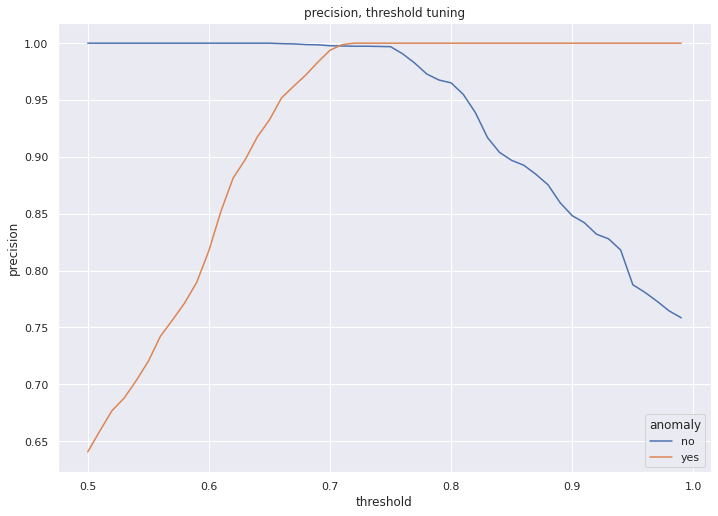

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=resultsDF, x="threshold", y="precision", hue="anomaly").set_title('precision, threshold tuning')

Text(0.5, 1.0, 'recall, threshold tuning')

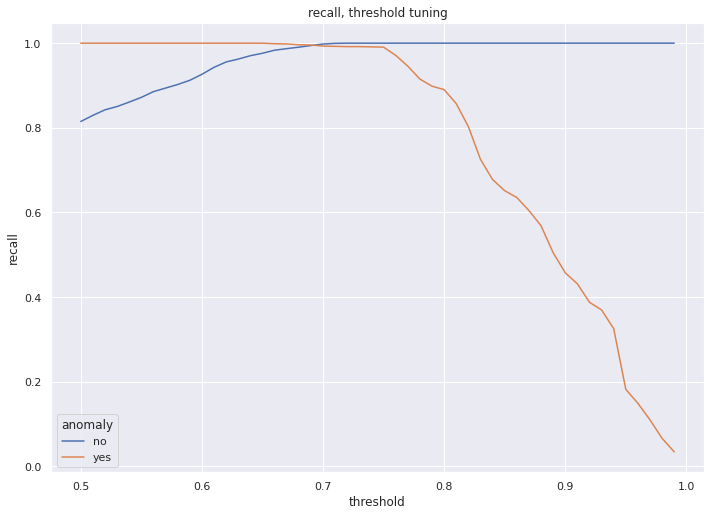

In [ ]:
sns.lineplot(data=resultsDF, x="threshold", y="recall", hue="anomaly").set_title('recall, threshold tuning')

Text(0.5, 1.0, 'fscore, threshold tuning')

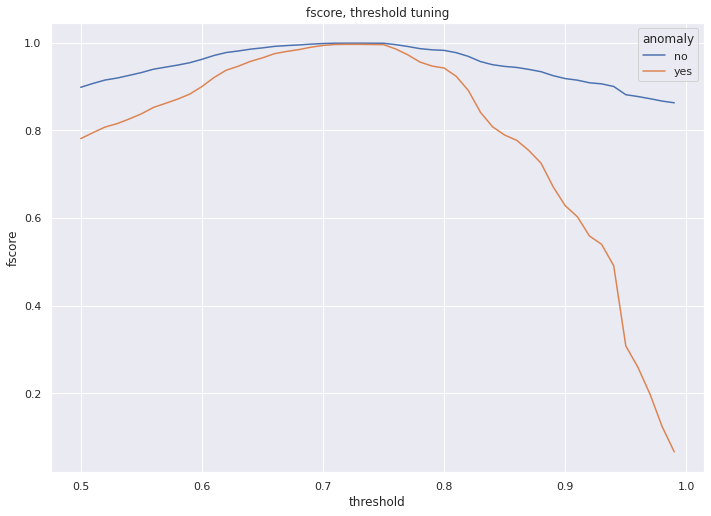

In [ ]:
sns.lineplot(data=resultsDF, x="threshold", y="fscore", hue="anomaly").set_title('fscore, threshold tuning')